![Logo UNAL CHEC](https://github.com/UN-GCPDS/curso_IA_CHEC/blob/main/logo_unal_chec.jpg?raw=1)

# **MÓDULO 2: APRENDIZAJE SUPERVISADO Y NO SUPERVISADO**



# **Configuración del Entorno de Trabajo**

In [1]:
# el comando `git clone <enlace_repositorio>` copia el contenido del repositorio en el directorio de trabajo
!git clone https://github.com/UN-GCPDS/curso_IA_CHEC.git
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.localbiplot.git --quiet    
# el comando `cd <carpeta>` cambia el directorio de trabajo
# en este caso, dejando el repositorio recién descargado
%cd "/kaggle/working/curso_IA_CHEC"

Cloning into 'curso_IA_CHEC'...
remote: Enumerating objects: 1001, done.
remote: Counting objects: 100% (248/248), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 1001 (delta 147), reused 223 (delta 133), pack-reused 753 (from 1)
Receiving objects: 100% (1001/1001), 42.81 MiB | 30.63 MiB/s, done.
Resolving deltas: 100% (639/639), done.
/kaggle/working/curso_IA_CHEC


## **Importación de Librerías**

In [2]:
! pip install umap-learn

In [3]:
# Ignorar advertencias
import warnings
warnings.filterwarnings("ignore")

# Manipulación de datos
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Reducción de dimensionalidad
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import umap

# Widgets interactivos
import ipywidgets as widgets
from ipywidgets import interact, fixed
from IPython.display import display

# Modelos de selección y evaluación
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Modelos de aprendizaje automático
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Métricas de evaluación
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Configuración de gráficos
sns.set()

# **Base de datos y su preprocesamiento**

## **Importación y Exploración Inicial de Datos**

Para esta práctica usaremos un dataset de interrupciones del fluido eléctrico en la red CHEC en algunos circuitos y transformadores, el cual está conformado por las siguientes columnas:
- **`periodo`:** mes al que corresponde
- **`evento`:** ID del evento
- **`equipo_ope`:** equipo que vio la interrupción
- **`tipo_equi_ope`:** tipo de equipo
- **`cto_equi_ope`:** tramo de red al que pertenece el servicio
- **`tipo_elemento`:** relacionado con la tensión a la que opera el equipo
- **`inicio`:** fecha y hora de inicio de la interrupción
- **`fin`:** fecha y hora de finalización de la interrupción
- **`duracion_h`:** duración de la interrupción
- **`tipo_duracion`:** si la interrupción duró más o menos de 3 minutos
- **`causa`:** codificación de la causa de la interrupción
- **`tipo_causa`:** causa que provocó la interrupción
- **`CNT_TRAFOS_AFEC`:** cantidad de trafos afectados
- **`cnt_usus`:** cantidad de usuarios afectados
- **`SAIDI`:** indicador de calidad del servicio por tiempo de falla
- **`SAIFI`:** indicador de calidad del servicio por cantidad de fallas


Estos datos se encuentran en formato CSV, por lo que para cargarlos usaremos la función [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). Además, en este caso usaremos algunos parámetros adicionales de acuerdo a la naturaleza de los datos:

- Como las columnas `inicio` y `fin` corresponden a fechas, indicaremos que se codifiquen de esta manera, y no como cadenas de texto, con el argumento `parse_dates`.
- Si bien la columna `causa` contiene valores numéricos, estos no deben ser tratados como tal ya que corresponden a causas de interrupciones en las que no hay una noción de orden. Por este motivo se leen como cadenas haciendo uso del parámetro `dtype`.
- Mediante una inspección previa se encontró que en algunas columnas se usan los caracteres `'-'` y `'XXX'` para indicar datos faltantes. Por defecto se leen como valores nulos únicamente los espacios vacíos, pero se pueden indicar valores adicionales a considerar como valores nulos con el argumento `na_values`.

In [4]:
interrupciones = pd.read_csv('Modulo1/databases/interrupciones.csv',
                             dtype={'causa': str}, parse_dates=['inicio', 'fin'], na_values=['-', 'XXX'])

Hagamos una exploración básica de la base de datos para tener una idea general de ella.

In [5]:
# Definir la función para mostrar información del DataFrame
def mostrar_informacion(opcion, num_filas=5):
    if opcion == 'Head':
        display(interrupciones.head(num_filas))
    elif opcion == 'Info':
        display(interrupciones.info())
    elif opcion == 'Descriptive Stats':
        display(interrupciones.describe())
    elif opcion == 'Shape':
        display(interrupciones.shape)
    elif opcion == 'Columns':
        display(interrupciones.columns.tolist())

# Crear el dropdown para seleccionar la opción
opcion_dropdown = widgets.Dropdown(
    options=['Head', 'Info', 'Descriptive Stats', 'Shape', 'Columns'],
    value='Head',  # Valor inicial (puedes cambiarlo a otra opción si lo deseas)
    description='Opción:',
)

# Crear un slider para el número de filas (solo visible cuando se selecciona 'Head')
num_filas_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=40,  # Máximo basado en el número de filas del DataFrame
    step=1,
    description='# filas:',
    continuous_update=False
)

# Mostrar el widget y la información interactiva
# Hacer que el slider solo se muestre si se selecciona 'Head'
def update_slider_visibility(opcion):
    if opcion == 'Head':
        return True
    else:
        return False

# Crear una función que muestre los widgets
def mostrar_widgets(opcion):
    display(opcion_dropdown)
    if update_slider_visibility(opcion):
        display(num_filas_slider)
    else:
        num_filas_slider.close()  # Cerrar el slider si no es necesario

# Conectar el dropdown a la función que muestra los widgets
widgets.interactive(mostrar_widgets, opcion=opcion_dropdown)

# Conectar la función de mostrar información con el dropdown y el slider
widgets.interactive(mostrar_informacion, opcion=opcion_dropdown, num_filas=num_filas_slider)

interactive(children=(Dropdown(description='Opción:', options=('Head', 'Info', 'Descriptive Stats', 'Shape', '…

En ocasiones no estamos interesados en trabajar con la totalidad del conjunto de datos, sino con algún subconjunto de este que cumpla condiciones específicas.

En este caso, nos centraremos en los registros de interrupciones tales que :

- El tipo de causa sea 'NP'.
- El tipo de elemento sea '13.2'.

In [6]:
condicion1 = interrupciones['tipo_causa'] == 'NP'
condicion2 = interrupciones['tipo_elemento'] == '13.2'
condiciones = condicion1 & condicion2
interrupciones_fltr = interrupciones[condiciones].reset_index(drop=True)

interrupciones_fltr = interrupciones_fltr.drop(['tipo_causa', 'tipo_elemento'], axis=1)
interrupciones_fltr.head()

,periodo,evento,equipo_ope,tipo_equi_ope,cto_equi_ope,inicio,fin,duracion_h,tipo_duracion,causa,CNT_TRAFOS_AFEC,cnt_usus,SAIDI,SAIFI
0,201901,7549851,FLR23L12,interruptor,FLR23L12,2019-01-01 02:37:15,2019-01-01 02:40:46,0.058611,> 3 min,39.0,53,347,0.000041,0.000697
1,201901,7549897,SNA5VCT3,interruptor,VCT23L13,2019-01-01 07:16:04,2019-01-01 08:12:27,0.939722,> 3 min,30.0,7,53,0.000100,0.000106
2,201901,7549897,SNA5VCT3,interruptor,VCT23L13,2019-01-01 07:16:04,2019-01-02 09:30:00,26.232222,> 3 min,30.0,10,99,0.005215,0.000199
3,201901,7549897,SNA5VCT3,interruptor,VCT23L13,2019-01-01 07:16:04,2019-01-02 16:20:00,33.065556,> 3 min,30.0,6,115,0.007636,0.000231
4,201901,7549923,GTO23L13,interruptor,GTO23L13,2019-01-01 11:59:01,2019-01-01 12:25:20,0.438611,> 3 min,30.0,59,164,0.000144,0.000329


Ahora que contamos con una idea inicial de la base de datos, ¡procedamos a llevar a cabo tareas de aprendizaje supervisado y no supervisado!

# **Aprendizaje supervisado**

## **Clasificación:** 
Entendemos que las interrupciones no son beneficiosas para la CHEC, por lo que proponemos como tarea inicial crear, entrenar y evaluar un modelo que nos permita determinar si una interrupción tuvo una duración superior a 3 minutos o fue de 3 minutos o menos.

Dado que el objetivo es clasificar la duración de las interrupciones, es decir, determinar si fueron mayores o menores a 3 minutos, eliminamos todas las columnas que se calculan después de obtener esta información, como el SAIFI, el SAIDI, el inicio, el fin y la duración en horas.

In [7]:
interrupciones_clasificacion = interrupciones_fltr.drop(['evento','SAIDI', 'SAIFI', 'inicio', 'fin', 'duracion_h'], axis=1)
interrupciones_clasificacion.head()

,periodo,equipo_ope,tipo_equi_ope,cto_equi_ope,tipo_duracion,causa,CNT_TRAFOS_AFEC,cnt_usus
0,201901,FLR23L12,interruptor,FLR23L12,> 3 min,39.0,53,347
1,201901,SNA5VCT3,interruptor,VCT23L13,> 3 min,30.0,7,53
2,201901,SNA5VCT3,interruptor,VCT23L13,> 3 min,30.0,10,99
3,201901,SNA5VCT3,interruptor,VCT23L13,> 3 min,30.0,6,115
4,201901,GTO23L13,interruptor,GTO23L13,> 3 min,30.0,59,164


### **Casteo de las variables categóricas**

Dado que contamos con variables categóricas (tipo objeto), es necesario volverlas numéricas para poder aplicar cualquier algoritmo de clasificación. A continuación puedes ver a qué vaor corresponde cada número y un vistazo de la tabla general.

In [8]:
interrupciones_clasificacion = interrupciones_fltr.drop(['evento','SAIDI', 'SAIFI', 'inicio', 'fin', 'duracion_h'], axis=1)

categorical_mappings = {}

for col in interrupciones_clasificacion.select_dtypes(include=['object']).columns:
    cat_column = pd.Categorical(interrupciones_clasificacion[col])
    categorical_mappings[col] = dict(enumerate(cat_column.categories))
    interrupciones_clasificacion[col] = cat_column.codes

# Crear el contenedor de salida
output = widgets.Output()

# Definir la función para mostrar información del DataFrame con scroll
def mostrar_informacion(opcion):
    with output:
        output.clear_output()  # Limpiar la salida anterior
        df = pd.DataFrame.from_dict(categorical_mappings[opcion], orient='index', columns=['Value'])
        
        # Mostrar el DataFrame con formato para los valores
        display(df.style.set_table_attributes('style="display:inline"').format(precision=2))

# Crear el dropdown para seleccionar la opción
opcion_dropdown = widgets.Dropdown(
    options=list(categorical_mappings.keys()),
    value=list(categorical_mappings.keys())[0],  # Valor inicial
    description='Opción:',
)

# Conectar el dropdown con la función de visualización
def on_change(change):
    mostrar_informacion(change['new'])

opcion_dropdown.observe(on_change, names='value')

# Mostrar el dropdown y el contenedor de salida con un scroll
scroll_layout = widgets.Layout(height='300px', overflow_y='scroll')

# Mostrar el dropdown y el área de salida
display(widgets.VBox([opcion_dropdown, widgets.Box([output], layout=scroll_layout)]))

# Mostrar la tabla inicial
mostrar_informacion(opcion_dropdown.value)


In [9]:
interrupciones_clasificacion.head(10)

,periodo,equipo_ope,tipo_equi_ope,cto_equi_ope,tipo_duracion,causa,CNT_TRAFOS_AFEC,cnt_usus
0,201901,3217,0,85,1,18,53,347
1,201901,5968,0,208,1,10,7,53
2,201901,5968,0,208,1,10,10,99
3,201901,5968,0,208,1,10,6,115
4,201901,3226,0,91,1,10,59,164
5,201901,2301,0,71,1,10,86,673
6,201901,5232,0,145,1,10,19,1682
7,201901,3226,0,91,1,10,59,164
8,201901,5232,0,145,1,10,19,1682
9,201901,5232,0,145,1,10,19,1682


### **Visualización de los datos**

Observamos que contamos con 8 columnas y que intentar visualizarlas todas al mismo tiempo resulta complicado. Por ello, es importante realizar una reducción de dimensionalidad para facilitar la visualización.

Por otro lado, un *biplot* permite representar las variables vectores que apuntan en la dirección en la que tienen mayor influencia en los datos. La longitud del vector indica la importancia de la variable en el análisis.

A continuación elige qué técnica de reducción utilizar y si se desea ver el biplot en PCA.

In [10]:
interrupciones_clasificacion_sampling = interrupciones_clasificacion.sample(n=5000, random_state=42)

X = interrupciones_clasificacion_sampling.drop(['tipo_duracion'], axis=1)
y = interrupciones_clasificacion_sampling['tipo_duracion']


# Normalizar los datos
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Suponiendo que ya has hecho el sampling y la normalización

# Función para aplicar reducción de dimensionalidad y graficar
def graficar_reduccion(tecnica, dim):
    if tecnica == 'PCA + biplot':
        localbiplot = lb.LocalBiplot(affine_='rotation',redm='umap')
        loading,rel_,score = localbiplot.biplot2D(pd.DataFrame(X_normalized, columns = X.columns),plot_=True,labels=y,loading_labels=X.columns)
    else:
        if tecnica == 'PCA':
            if dim == '2D':
                modelo = PCA(n_components=2)
            else:
                modelo = PCA(n_components=3)
        elif tecnica == 't-SNE':
            if dim == '2D':
                modelo = TSNE(n_components=2, random_state=42)
            else:
                modelo = TSNE(n_components=3, random_state=42)
        elif tecnica == 'UMAP':
            if dim == '2D':
                modelo = umap.UMAP(n_components=2, random_state=42)
            else:
                modelo = umap.UMAP(n_components=3, random_state=42)

        # Aplicar el modelo seleccionado
        X_reduccion = modelo.fit_transform(X_normalized)

        # Crear un DataFrame con las componentes y las etiquetas
        if dim == '2D':
            df_reduccion = pd.DataFrame(data=X_reduccion, columns=['Componente 1', 'Componente 2'])
            df_reduccion['Clase'] = y.to_numpy(dtype='str')

            # Crear el scatter plot en 2D
            plt.figure(figsize=(10, 7))
            sns.scatterplot(data=df_reduccion, x='Componente 1', y='Componente 2', hue='Clase', palette='viridis', alpha=0.7)
            plt.title(f'{tecnica} en {dim}')
            plt.xlabel('Componente 1')
            plt.ylabel('Componente 2')
            plt.legend(title='Clase')
            plt.grid()
            plt.show()

        else:
            df_reduccion = pd.DataFrame(data=X_reduccion, columns=['Componente 1', 'Componente 2', 'Componente 3'])
            df_reduccion['Clase'] = y.to_numpy(dtype='str')

            # Crear el scatter plot en 3D
            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(df_reduccion['Componente 1'], df_reduccion['Componente 2'], df_reduccion['Componente 3'],
                                 c=pd.factorize(df_reduccion['Clase'])[0], cmap='viridis', alpha=0.7)

            # Crear la leyenda
            legend1 = ax.legend(*scatter.legend_elements(), title='Clases')
            ax.add_artist(legend1)
            ax.set_title(f'{tecnica} en {dim}')
            ax.set_xlabel('Componente 1')
            ax.set_ylabel('Componente 2')
            ax.set_zlabel('Componente 3')
            plt.show()

# Dropdown para seleccionar la técnica de reducción de dimensionalidad
tecnica_dropdown = widgets.Dropdown(
    options=['PCA', 't-SNE', 'UMAP', 'PCA + biplot'],
    value='PCA',  # Valor inicial
    description='Método:'
)

# Dropdown para seleccionar la dimensión (2D o 3D)
dim_dropdown = widgets.Dropdown(
    options=['2D', '3D'],
    value='2D',  # Valor inicial
    description='Dimensiones:'
)

# Mostrar los widgets y graficar la reducción dimensional interactiva
widgets.interactive(graficar_reduccion, tecnica=tecnica_dropdown, dim=dim_dropdown)


interactive(children=(Dropdown(description='Método:', options=('PCA', 't-SNE', 'UMAP', 'PCA + biplot'), value=…

En nuestro caso, podemos observar que las variables que tienen mayor impotancia son `periodo`, `equipo_ope` y `cto_equi_ope`.

### **Elección del clasificador:**

Ahora, selecciona el clasificador con el ajuste de hiperparámetro correspondiente que consideres está funcionando mejor. Un buen valor de accuracy general no implica necesariamente que sea el mejor clasificador; también es importante considerar su rendimiento en cada clase.

In [11]:
X = interrupciones_clasificacion.drop(['tipo_duracion'], axis=1)
y = interrupciones_clasificacion['tipo_duracion']


# Normalizar los datos
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Variable global para almacenar el modelo entrenado
trained_model = None

# Crear una función para entrenar y evaluar el clasificador
def clasificar_y_evaluar(clasificador, n_neighbors=3, c_value_logistic=1.0, c_value_svc=1.0, max_depth=None):
    global trained_model  # Permite modificar la variable global

    # Dividir el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
    
    # Crear y entrenar el clasificador
    if clasificador == 'Regresión Logística':
        model = LogisticRegression(C=c_value_logistic, max_iter=1000)
    elif clasificador == 'Árbol de Decisión':
        model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    elif clasificador == 'K-Vecinos Más Cercanos':
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
    elif clasificador == 'Máquinas de Vectores de Soporte':
        model = SVC(C=c_value_svc)

    # Ajustar el modelo a los datos
    model.fit(X_train, y_train)
    
    # Guardar el modelo entrenado en la variable global
    global trained_model
    trained_model = model  # Ahora puedes usar 'trained_model' en otras celdas

    # Hacer predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular la precisión
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy del clasificador {clasificador}: {accuracy:.2f}')
    
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Calcular porcentajes de aciertos
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    conf_matrix_percentage = np.nan_to_num(conf_matrix_percentage) * 100  # Reemplaza NaN con 0%

    # Visualizar la matriz de confusión con valores absolutos
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)  # Gráfica 1 de 2
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                 xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'Matriz de Confusión para {clasificador} (Conteos)')
    plt.xlabel('Predicciones')
    plt.ylabel('Actual')

    # Visualizar la matriz de confusión con porcentajes
    plt.subplot(1, 2, 2)  # Gráfica 2 de 2
    sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', cbar=False,
                 xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'Matriz de Confusión para {clasificador} (Porcentaje)')
    plt.xlabel('Predicciones')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

# Crear el dropdown para seleccionar el clasificador
clasificador_dropdown = widgets.Dropdown(
    options=['Regresión Logística', 'Árbol de Decisión', 'K-Vecinos Más Cercanos', 'Máquinas de Vectores de Soporte'],
    value='Regresión Logística',  # Valor inicial
    description='Clasificador:',
)

# Crear un deslizador para la cantidad de vecinos (solo para KNN)
n_neighbors_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=20,
    step=2,
    description='Vecinos:',
    continuous_update=False
)

# Deslizador para el hiperparámetro C en la regresión logística
c_slider_logistic = widgets.FloatSlider(
    value=1.0,
    min=0.01,
    max=1000,
    step=10,
    description='C (Reg. Log.):',
    continuous_update=False
)

# Deslizador para el hiperparámetro C en SVC
c_slider_svc = widgets.FloatSlider(
    value=1.0,
    min=0.01,
    max=1000,
    step=10,
    description='C (SVC):',
    continuous_update=False
)

# Deslizador para la profundidad del árbol de decisión
depth_slider = widgets.IntSlider(
    value=None,
    min=1,
    max=20,
    step=2,
    description='Profundidad (Árbol):',
    continuous_update=False
)

# Función para mostrar los deslizadores relevantes según el clasificador
def update_slider_visibility(selected_classifier):
    if selected_classifier == 'K-Vecinos Más Cercanos':
        n_neighbors_slider.layout.visibility = 'visible'
        c_slider_logistic.layout.visibility = 'hidden'
        c_slider_svc.layout.visibility = 'hidden'
        depth_slider.layout.visibility = 'hidden'
    elif selected_classifier == 'Regresión Logística':
        n_neighbors_slider.layout.visibility = 'hidden'
        c_slider_logistic.layout.visibility = 'visible'
        c_slider_svc.layout.visibility = 'hidden'
        depth_slider.layout.visibility = 'hidden'
    elif selected_classifier == 'Árbol de Decisión':
        n_neighbors_slider.layout.visibility = 'hidden'
        c_slider_logistic.layout.visibility = 'hidden'
        c_slider_svc.layout.visibility = 'hidden'
        depth_slider.layout.visibility = 'visible'
    elif selected_classifier == 'Máquinas de Vectores de Soporte':
        n_neighbors_slider.layout.visibility = 'hidden'
        c_slider_logistic.layout.visibility = 'hidden'
        c_slider_svc.layout.visibility = 'visible'
        depth_slider.layout.visibility = 'hidden'

# Conectar la función de actualización a la selección del dropdown
clasificador_dropdown.observe(lambda change: update_slider_visibility(change['new']), names='value')
update_slider_visibility(clasificador_dropdown.value)  # Inicializar visibilidad

# Mostrar el widget y ejecutar la clasificación interactiva
interactive_output = widgets.interactive(clasificar_y_evaluar, 
                    clasificador=clasificador_dropdown, 
                    n_neighbors=n_neighbors_slider, 
                    c_value_logistic=c_slider_logistic,
                    c_value_svc=c_slider_svc,
                    max_depth=depth_slider)

# Desplegar el widget
display(interactive_output)

interactive(children=(Dropdown(description='Clasificador:', options=('Regresión Logística', 'Árbol de Decisión…

### **Predicciones con el modelo seleccionado**

Imagina que se produce una nueva interrupción, para la cual dispones de los siguientes datos: el período, el equipo operativo (`equipo_ope`), el tipo de equipo operativo (`tipo_equi_ope`), el código del equipo operativo (`cto_equi_ope`), la causa, la cantidad de transformadores afectados (`CNT_TRAFOS_AFEC`) y el número de usuarios afectados (`cnt_usus`). El objetivo del modelo entrenado es predecir a cuál de las dos clases pertenece la interrupción: si su duración será mayor a 3 minutos o menor o igual a 3 minutos.

Al ingresar un nuevo dato, ten en cuenta que todas las variables son numéricas. No olvides verificar a qué categoría corresponde cada número y el formato correcto de los datos.

In [12]:
# Crear el contenedor de salida
output = widgets.Output()

# Definir la función para mostrar información del DataFrame con scroll
def mostrar_informacion(opcion):
    with output:
        output.clear_output()  # Limpiar la salida anterior
        df = pd.DataFrame.from_dict(categorical_mappings[opcion], orient='index', columns=['Value'])
        
        # Mostrar el DataFrame con formato para los valores
        display(df.style.set_table_attributes('style="display:inline"').format(precision=2))

# Crear el dropdown para seleccionar la opción
opcion_dropdown = widgets.Dropdown(
    options=list(categorical_mappings.keys()),
    value=list(categorical_mappings.keys())[0],  # Valor inicial
    description='Opción:',
)

# Conectar el dropdown con la función de visualización
def on_change(change):
    mostrar_informacion(change['new'])

opcion_dropdown.observe(on_change, names='value')

# Mostrar el dropdown y el contenedor de salida con un scroll
scroll_layout = widgets.Layout(height='300px', overflow_y='scroll')

# Mostrar el dropdown y el área de salida
display(widgets.VBox([opcion_dropdown, widgets.Box([output], layout=scroll_layout)]))

# Mostrar la tabla inicial
mostrar_informacion(opcion_dropdown.value)


In [13]:
X.head()

,periodo,equipo_ope,tipo_equi_ope,cto_equi_ope,causa,CNT_TRAFOS_AFEC,cnt_usus
0,201901,3217,0,85,18,53,347
1,201901,5968,0,208,10,7,53
2,201901,5968,0,208,10,10,99
3,201901,5968,0,208,10,6,115
4,201901,3226,0,91,10,59,164


In [14]:
print('Ingresa los valores del dato nuevo:')

# Crear un área de salida para mostrar los resultados
salida = widgets.Output()

# Widgets para las columnas numéricas con valores por defecto
periodo_input = widgets.IntText(description='Periodo:', value=202408)
cnt_trafos_afec_input = widgets.IntText(description='CNT_TRAFOS_AFEC:', value=200)
cnt_usus_input = widgets.IntText(description='cnt_usus:', value=950)

# Widgets para columnas categóricas o de texto con valores por defecto
equipo_ope_input = widgets.IntText(description='equipo_ope:', value=5290)
tipo_equi_ope_input = widgets.IntText(description='tipo_equi_ope:', value=0)
cto_equi_ope_input = widgets.IntText(description='cto_equi_ope:', value=40)
causa_input = widgets.IntText(description='Causa:', value=5)

# Botón para predecir
predict_button = widgets.Button(description="Predecir")

# Función para hacer la predicción y mostrar el resultado en el área de salida
def hacer_prediccion(b):
    with salida:
        salida.clear_output()  # Limpiar la salida anterior
        
        # Recoger los valores de entrada
        nuevo_dato = {
            'periodo': periodo_input.value,
            'equipo_ope': equipo_ope_input.value,
            'tipo_equi_ope': tipo_equi_ope_input.value,
            'cto_equi_ope': cto_equi_ope_input.value,
            'causa': causa_input.value,
            'CNT_TRAFOS_AFEC': cnt_trafos_afec_input.value,
            'cnt_usus': cnt_usus_input.value
        }
        
        # Crear un DataFrame con el nuevo dato
        nuevo_dato_df = pd.DataFrame([nuevo_dato])
        
        # Normalizar los datos (si se utilizó normalización en el entrenamiento)
        nuevo_dato_normalized = scaler.transform(nuevo_dato_df)

        # Hacer la predicción usando el modelo entrenado
        prediccion = trained_model.predict(nuevo_dato_normalized)
        
        clases = ['<= 3min', '> 3min']
        # Mostrar la predicción
        print(f"Predicción: {clases[prediccion[0]]}")

# Conectar el botón con la función de predicción
predict_button.on_click(hacer_prediccion)

# Mostrar los widgets de entrada y el botón
display(periodo_input, equipo_ope_input, tipo_equi_ope_input, cto_equi_ope_input, causa_input,
        cnt_trafos_afec_input, cnt_usus_input, predict_button)

# Mostrar el área de salida
display(salida)

Ingresa los valores del dato nuevo:


IntText(value=202408, description='Periodo:')

IntText(value=5290, description='equipo_ope:')

IntText(value=0, description='tipo_equi_ope:')

IntText(value=40, description='cto_equi_ope:')

IntText(value=5, description='Causa:')

IntText(value=200, description='CNT_TRAFOS_AFEC:')

IntText(value=950, description='cnt_usus:')

Button(description='Predecir', style=ButtonStyle())

Output()

## **Regresión**

Entendemos que las interrupciones no son beneficiosas para la CHEC, por lo que proponemos como tarea inicial crear, entrenar y evaluar un modelo que nos permita determinar la duración de la interrupción en horas.

Dado que el objetivo es hacer un regresor de la duración de las interrupciones, eliminamos todas las columnas que se calculan después de obtener esta información, como el SAIFI, el SAIDI, el inicio, el fin y la duración en horas.

In [15]:
interrupciones_regresion = interrupciones_fltr.drop(['evento','SAIDI', 'SAIFI', 'inicio', 'fin', 'tipo_duracion'], axis=1)
interrupciones_regresion.head()

for col in interrupciones_regresion.select_dtypes(include=['object']).columns:
    interrupciones_regresion[col] = pd.Categorical(interrupciones_fltr[col]).codes
    
interrupciones_regresion.head()

,periodo,equipo_ope,tipo_equi_ope,cto_equi_ope,duracion_h,causa,CNT_TRAFOS_AFEC,cnt_usus
0,201901,3217,0,85,0.058611,18,53,347
1,201901,5968,0,208,0.939722,10,7,53
2,201901,5968,0,208,26.232222,10,10,99
3,201901,5968,0,208,33.065556,10,6,115
4,201901,3226,0,91,0.438611,10,59,164


¿Es posible obtener un regresor lineal con buen rendimiento? 

¡Probemos!

### **Regresiones lineales**

Prueba los diferentes regresores lineales y ajusta los hiperparámetros, ¿en alguno las métricas mejoran de manera significativa?

Las métricas que utilizamos son:

- MAE (Mean Absolute Error): Es el promedio de las diferencias absolutas entre las predicciones y los valores reales. Mide el error promedio sin tener en cuenta la dirección de los errores.

- MSE (Mean Squared Error): Promedio de los errores al cuadrado entre las predicciones y los valores reales. Penaliza más los errores grandes al elevarlos al cuadrado.

- MAPE (Mean Absolute Percentage Error): Promedio del error absoluto expresado como un porcentaje de los valores reales, útil para interpretar errores relativos.

- R² (Coeficiente de Determinación): Mide la proporción de la varianza explicada por el modelo. Un valor cercano a 1 indica un buen ajuste, mientras que un valor cercano a 0 indica lo contrario.

In [16]:
interrupciones_regresion_sampling = interrupciones_regresion.sample(n=5000, random_state=42)


X = interrupciones_regresion_sampling.drop(['duracion_h'], axis=1)
y = interrupciones_regresion_sampling['duracion_h']

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Función para entrenar, evaluar el modelo y generar la gráfica
def train_evaluate_model(model_name, alpha=1.0, l1_ratio=0.5):
    # Selección del modelo basado en el menú desplegable
    if model_name == 'Linear':
        model = LinearRegression()
    elif model_name == 'Ridge':
        model = Ridge(alpha=alpha)
    elif model_name == 'Lasso':
        model = Lasso(alpha=alpha)
    elif model_name == 'ElasticNet':
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    
    # Entrenamiento del modelo
    model.fit(X_train, y_train)
    
    # Predicción
    y_pred = model.predict(X_test)
    
    # Post-procesamiento para asegurar que las predicciones no sean negativas
#     y_pred = np.clip(y_pred, a_min=0, a_max=None)  # Limita los valores predichos a no ser negativos
    
    # Cálculo de métricas
    ame = mean_absolute_error(y_test, y_pred)  # Error absoluto medio
    mse = mean_squared_error(y_test, y_pred)   # Error cuadrático medio
    mape = mean_absolute_percentage_error(y_test, y_pred)  # Error absoluto medio porcentual
    r2 = r2_score(y_test, y_pred)  # R²
    
    # Impresión de métricas con 8 decimales
    print(f"Modelo: {model_name}")
    print(f"AME (Error absoluto medio): {ame:.8f}")
    print(f"MSE (Error cuadrático medio): {mse:.8f}")
    print(f"MAPE (Error absoluto medio porcentual): {mape:.8f}")
    print(f"R² (Coeficiente de determinación): {r2:.8f}")
    print("-" * 40)
    
    # Crear la gráfica comparativa
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label='Valores reales', marker='o')
    plt.plot(y_pred, label='Valores predichos', marker='x')
    plt.title(f'Comparación de etiquetas reales vs predichas ({model_name})')
    plt.xlabel('Índice')
    plt.ylabel('Valores')
    plt.legend()
    plt.grid(True)
    plt.show()

# Crear los deslizadores
alpha_slider = widgets.FloatSlider(value=1.0, min=0.01, max=10.0, step=0.01, description='Alpha:', continuous_update=False)
l1_ratio_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='L1 Ratio:', continuous_update=False)

# Función para actualizar el deslizador dependiendo del modelo seleccionado
def update_slider_visibility(model_name):
    if model_name == 'Linear':
        alpha_slider.layout.visibility = 'hidden'
        l1_ratio_slider.layout.visibility = 'hidden'
    elif model_name == 'Ridge' or model_name == 'Lasso':
        alpha_slider.layout.visibility = 'visible'
        l1_ratio_slider.layout.visibility = 'hidden'
    elif model_name == 'ElasticNet':
        alpha_slider.layout.visibility = 'visible'
        l1_ratio_slider.layout.visibility = 'visible'

# Menú desplegable para seleccionar el modelo
model_selector = widgets.Dropdown(
    options=['Linear', 'Ridge', 'Lasso', 'ElasticNet'],
    value='Linear',
    description='Modelo:',
)

# Conectar la función de actualización a la selección del dropdown
model_selector.observe(lambda change: update_slider_visibility(change['new']), names='value')

# Inicializar visibilidad de los sliders
update_slider_visibility(model_selector.value)

# Crear el widget interactivo
interactive_output = widgets.interactive_output(train_evaluate_model, 
                                                {'model_name': model_selector, 
                                                 'alpha': alpha_slider, 
                                                 'l1_ratio': l1_ratio_slider})

# Mostrar los widgets y ejecutar la regresión interactiva
display(model_selector, alpha_slider, l1_ratio_slider, interactive_output)

Dropdown(description='Modelo:', options=('Linear', 'Ridge', 'Lasso', 'ElasticNet'), value='Linear')

FloatSlider(value=1.0, continuous_update=False, description='Alpha:', layout=Layout(visibility='hidden'), max=…

FloatSlider(value=0.5, continuous_update=False, description='L1 Ratio:', layout=Layout(visibility='hidden'), m…

Output()

Podemos notar que a pesar de variar de modelo y de ajustar los hiperparámetros el rendimiento no mejora significativamente, y en general, es malo. Esto puede deberse a diversas razones:

1. **Relación no lineal**: Si la relación entre las variables independientes y la dependiente no es lineal, el modelo no podrá capturar adecuadamente las tendencias.

2. **Colinealidad**: Cuando las variables independientes están altamente correlacionadas entre sí, esto puede distorsionar los coeficientes del modelo.

3. **Datos insuficientes o ruido**: Pocos datos o datos con mucho ruido (variabilidad no explicada) pueden dificultar que el modelo generalice correctamente.

4. **Ausencia de variables relevantes**: Si faltan variables importantes, el modelo no tendrá toda la información necesaria para hacer buenas predicciones.

5. **Outliers**: Valores atípicos pueden influir de manera desproporcionada en el ajuste del modelo.

Así que probemos regresores no lineales.

### **Regresores no lineales**

Algunas de las técnicas de regresión no lineales más comunes son:

1. **Kernel Ridge**: Es una extensión de la regresión ridge que usa kernels para modelar relaciones no lineales. Combina la penalización L2 (ridge) con el uso de un kernel (como RBF o polinómico) para proyectar los datos a un espacio de mayor dimensión, donde las relaciones no lineales pueden modelarse linealmente.

2. **Árbol de Decisión:**: Los árboles de regresión dividen los datos en subconjuntos basados en reglas de decisión iterativas (si/entonces), buscando minimizar la varianza en cada subconjunto. Funciona bien con relaciones no lineales y no requiere normalización de datos.

3. **Vectores de Soporte:**: Busca encontrar una función que tenga el mayor margen posible (epsilon) para predecir valores dentro de un rango, ignorando errores pequeños. También puede usarse con kernels para capturar relaciones no lineales.

In [17]:
interrupciones_regresion_sampling = interrupciones_regresion.sample(n=5000, random_state=42)

X = interrupciones_regresion_sampling.drop(['duracion_h'], axis=1)
y = interrupciones_regresion_sampling['duracion_h']

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Función para entrenar, evaluar el modelo y generar la gráfica
def entrenar_evaluar_modelo(nombre_modelo, arbol=2, kernel=1, gaussiano=1.0, svr=1.0):
    # Selección del modelo basado en el menú desplegable
    if nombre_modelo == 'Árbol de Decisión':
        modelo = DecisionTreeRegressor(max_depth=int(arbol))  # max_depth es el hiperparámetro
    elif nombre_modelo == 'Kernel Ridge':
        modelo = KernelRidge(alpha=kernel)  # alpha es el hiperparámetro
    elif nombre_modelo == 'Máquinas de Soporte Vectorial (SVR)':
        modelo = SVR(C=svr)  # C es el hiperparámetro

    # Entrenamiento del modelo
    modelo.fit(X_train, y_train)
    
    # Predicción
    y_pred = modelo.predict(X_test)
    
    # Post-procesamiento para asegurar que las predicciones no sean negativas
    y_pred = np.clip(y_pred, a_min=0, a_max=None)  # Limita los valores predichos a no ser negativos
    
    # Cálculo de métricas
    ame = mean_absolute_error(y_test, y_pred)  # Error absoluto medio
    mse = mean_squared_error(y_test, y_pred)   # Error cuadrático medio
    mape = mean_absolute_percentage_error(y_test, y_pred)  # Error absoluto medio porcentual
    r2 = r2_score(y_test, y_pred)  # R²
    
    # Impresión de métricas con 8 decimales
    print(f"Modelo: {nombre_modelo}")
    print(f"AME (Error absoluto medio): {ame:.8f}")
    print(f"MSE (Error cuadrático medio): {mse:.8f}")
    print(f"MAPE (Error absoluto medio porcentual): {mape:.8f}")
    print(f"R² (Coeficiente de determinación): {r2:.8f}")
    print("-" * 40)
    
    # Crear la gráfica comparativa
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label='Valores reales', marker='o')
    plt.plot(y_pred, label='Valores predichos', marker='x')
    plt.title(f'Comparación de etiquetas reales vs predichas ({nombre_modelo})')
    plt.xlabel('Índice')
    plt.ylabel('Valores')
    plt.legend()
    plt.grid(True)
    plt.show()

# Crear deslizadores para los hiperparámetros
max_depth_slider = widgets.IntSlider(value=3, min=1, max=20, step=1, description='Profundidad máxima (Árbol):', continuous_update=False)
alpha_slider_kernel_ridge = widgets.FloatSlider(value=1.0, min=0.01, max=10.0, step=0.01, description='Alpha (Cresta Kernel):', continuous_update=False)
c_slider_svr = widgets.FloatSlider(value=1.0, min=0.01, max=10.0, step=0.01, description='C (SVR):', continuous_update=False)

# Función para actualizar la visibilidad de los deslizadores según el modelo seleccionado
def actualizar_visibilidad_deslizadores(nombre_modelo):
    if nombre_modelo == 'Árbol de Decisión':
        max_depth_slider.layout.visibility = 'visible'
        alpha_slider_kernel_ridge.layout.visibility = 'hidden'
        c_slider_svr.layout.visibility = 'hidden'
    elif nombre_modelo == 'Kernel Ridge':
        max_depth_slider.layout.visibility = 'hidden'
        alpha_slider_kernel_ridge.layout.visibility = 'visible'
        c_slider_svr.layout.visibility = 'hidden'
    elif nombre_modelo == 'Máquinas de Soporte Vectorial (SVR)':
        max_depth_slider.layout.visibility = 'hidden'
        alpha_slider_kernel_ridge.layout.visibility = 'hidden'
        c_slider_svr.layout.visibility = 'visible'

# Menú desplegable para seleccionar el modelo
selector_modelo = widgets.Dropdown(
    options=['Árbol de Decisión', 'Kernel Ridge', 'Máquinas de Soporte Vectorial (SVR)'],
    value='Árbol de Decisión',
    description='Modelo:',
)

# Conectar la función de actualización a la selección del dropdown
selector_modelo.observe(lambda change: actualizar_visibilidad_deslizadores(change['new']), names='value')

# Inicializar visibilidad de los sliders
actualizar_visibilidad_deslizadores(selector_modelo.value)

# Crear el widget interactivo
salida_interactiva = widgets.interactive_output(entrenar_evaluar_modelo, 
                                                {'nombre_modelo': selector_modelo, 
                                                 'arbol': max_depth_slider,
                                                 'kernel': alpha_slider_kernel_ridge,
                                                 'svr': c_slider_svr})

# Mostrar los widgets y ejecutar la regresión interactiva
display(selector_modelo, max_depth_slider, alpha_slider_kernel_ridge, c_slider_svr, salida_interactiva)


Dropdown(description='Modelo:', options=('Árbol de Decisión', 'Kernel Ridge', 'Máquinas de Soporte Vectorial (…

IntSlider(value=3, continuous_update=False, description='Profundidad máxima (Árbol):', layout=Layout(visibilit…

FloatSlider(value=1.0, continuous_update=False, description='Alpha (Cresta Kernel):', layout=Layout(visibility…

FloatSlider(value=1.0, continuous_update=False, description='C (SVR):', layout=Layout(visibility='hidden'), ma…

Output()

Seguimos observando que estos regresores no logran capturar correctamente el valor de la duración en horas. ¡Esto es un claro reflejo de un escenario típico en la vida real! Sin embargo, esto no significa que la tarea sea imposible. Existen varias estrategias que podemos implementar:

- **Balancear los datos**: Si los datos están desequilibrados (por ejemplo, muchas interrupciones cortas y pocas largas), es posible que los modelos no estén aprendiendo bien las relaciones subyacentes. Técnicas como sobremuestreo de las clases minoritarias, submuestreo de las mayoritarias o el uso de métodos como SMOTE pueden ayudar a mejorar el rendimiento.
  
- **Discretizar la variable y convertirla en una tarea de clasificación**: En lugar de predecir un valor continuo, podemos agrupar la duración en rangos y convertir el problema en una tarea de clasificación, lo que puede ser más fácil para algunos modelos de capturar.

- **Incluir nuevas características**: Agregar variables adicionales relevantes, como datos temporales (hora del día, día de la semana) o indicadores climáticos, podría mejorar las predicciones al proporcionar más contexto.

- **Probar modelos más complejos**: Modelos como redes neuronales, modelos de ensamble (e.g., Random Forest, XGBoost), o arquitecturas más sofisticadas como redes neuronales recurrentes (RNN) podrían capturar mejor las relaciones complejas en los datos.

- **Realizar ingeniería de características**: Transformar o combinar variables existentes para crear nuevas características que mejor representen patrones no capturados actualmente por los modelos.

Estas estrategias pueden ser útiles para mejorar el rendimiento en escenarios complejos y algunas las abordaremos más adelante en el curso.

# **Aprendizaje no supervisado**

Para visualizar mejor los datos, utilizaremos PCA (Análisis de Componentes Principales). Recuerda que en el aprendizaje no supervisado, el modelo trabaja únicamente con los datos sin etiquetas, por lo que esta es la información que "ve" el modelo.

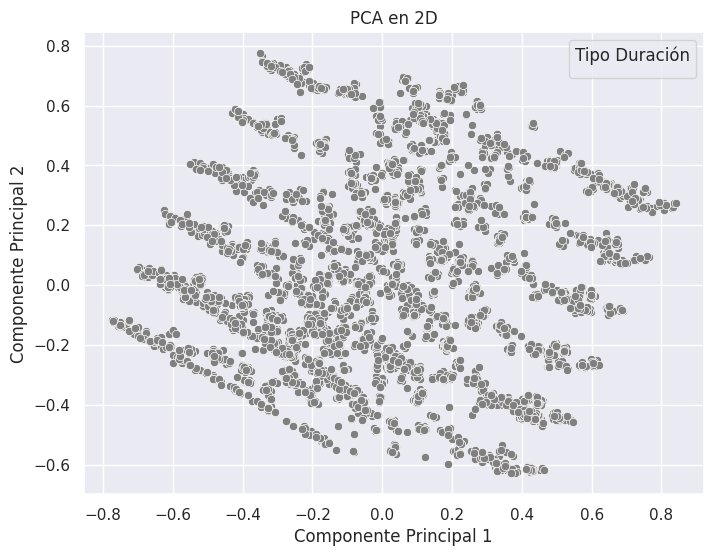

In [18]:
interrupciones_clasificacion_sampling = interrupciones_clasificacion.sample(n=5000, random_state=42)


# Preparar los datos para PCA
X = interrupciones_clasificacion_sampling.drop(['tipo_duracion'], axis=1)
y = interrupciones_clasificacion_sampling['tipo_duracion']

# Normalizar los datos
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Aplicar PCA para 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Crear un DataFrame para los componentes principales y las etiquetas
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# Crear el scatter plot en 2D con Matplotlib y Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2',data=df_pca, color='gray')

# Etiquetas y título
plt.title('PCA en 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Tipo Duración')
plt.show()


## **Conglomerados**

El propósito es organizar un conjunto de datos en grupos o "conglomerados" de tal manera que los objetos dentro de un mismo grupo sean más similares entre sí que a los de otros grupos. Es decir, se trata de encontrar una estructura subyacente en los datos sin que existan etiquetas predefinidas, como ocurre en los métodos supervisados.

In [19]:
from sklearn.cluster import KMeans, DBSCAN

# Variable global para almacenar las etiquetas de los clusters
cluster_labels = None

# Crear una función para realizar el clustering y PCA
def clustering_y_visualizacion(metodo, n_clusters=3, eps=0.5, min_samples=5):
    global cluster_labels  # Permite modificar la variable global

    if metodo == 'K-Means':
        # Aplicar K-Means
        model = KMeans(n_clusters=n_clusters, random_state=42, max_iter=300)
        cluster_labels = model.fit_predict(X_normalized)
    elif metodo == 'DBSCAN':
        # Aplicar DBSCAN
        model = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = model.fit_predict(X_normalized)
    
    # Aplicar PCA para reducir la dimensionalidad
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_normalized)

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=100, alpha=0.7)
    plt.title(f'Visualización de Clusters con {metodo}')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend(title='Clusters')
    plt.grid(True)
    plt.show()

# Crear el dropdown para seleccionar el método de agrupamiento
metodo_dropdown = widgets.Dropdown(
    options=['K-Means', 'DBSCAN'],
    value='K-Means',  # Valor inicial
    description='Método:',
)

# Crear un deslizador para la cantidad de clusters (solo para K-Means)
n_clusters_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=10,
    step=1,
    description='Clusters:',
    continuous_update=False
)

# Deslizador para el parámetro eps en DBSCAN
eps_slider = widgets.FloatSlider(
    value=0.5,
    min=0.1,
    max=5.0,
    step=0.1,
    description='Epsilon (DBSCAN):',
    continuous_update=False
)

# Deslizador para el parámetro min_samples en DBSCAN
min_samples_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=20,
    step=1,
    description='Min Samples (DBSCAN):',
    continuous_update=False
)

# Función para mostrar los deslizadores relevantes según el método
def update_slider_visibility(selected_method):
    if selected_method == 'K-Means':
        n_clusters_slider.layout.visibility = 'visible'
        eps_slider.layout.visibility = 'hidden'
        min_samples_slider.layout.visibility = 'hidden'
    elif selected_method == 'DBSCAN':
        n_clusters_slider.layout.visibility = 'hidden'
        eps_slider.layout.visibility = 'visible'
        min_samples_slider.layout.visibility = 'visible'

# Conectar la función de actualización a la selección del dropdown
metodo_dropdown.observe(lambda change: update_slider_visibility(change['new']), names='value')
update_slider_visibility(metodo_dropdown.value)  # Inicializar visibilidad

# Mostrar el widget y ejecutar la agrupación interactiva
interactive_output = widgets.interactive(clustering_y_visualizacion, 
                    metodo=metodo_dropdown, 
                    n_clusters=n_clusters_slider, 
                    eps=eps_slider,
                    min_samples=min_samples_slider)

# Desplegar el widget
display(interactive_output)

interactive(children=(Dropdown(description='Método:', options=('K-Means', 'DBSCAN'), value='K-Means'), IntSlid…

**No obtuvimos el resultado que esperábamos, ¿verdad?**

A pesar de que sabemos que existen dos grupos en nuestros datos (interrupciones eléctricas que duran más o menos de 3 minutos), los algoritmos de agrupamiento pueden no segmentar los datos de la forma anticipada. Esto puede ocurrir por varias razones:

1. **Hiperparámetros**:
   - Cada método de agrupamiento tiene múltiples hiperparámetros que, aunque no siempre son evidentes, impactan significativamente en los resultados.
     - **K-means**: Es necesario determinar el número de grupos y cómo se inicializan los centroides. Estas decisiones pueden modificar drásticamente la agrupación final.
     - **DBSCAN**: Este método depende de parámetros de densidad, como el radio de búsqueda y el número mínimo de puntos en un vecindario. Una selección inadecuada de estos parámetros puede conducir a interpretaciones erróneas.

2. **Agrupaciones alternativas**:
   - Aunque consideramos dos clases (mayor a 3 minutos y menor a 3 minutos), los conglomerados pueden estar capturando relaciones diferentes.
   - Por ejemplo, en un conjunto de datos de interrupciones eléctricas, los grupos podrían formarse en función de patrones de frecuencia, del tipo de interrupción o de la hora del día, en lugar de la duración.

Te animamos a que sigas explorando y profundizando en este tema, porque las bases de datos reales no son tan sencillas de manejar.